In [2]:
import pkg_resources
from pyforest import *
import datetime, pickle, copy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import quandl
plt.style.use('ggplot')
from statistics import variance 
from random import randint
import scipy as sp
from scipy import stats

import ffn
from matplotlib import cm
import numpy as np

from sklearn.preprocessing import scale # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, r2_score
import sklearn.mixture as mix
import math, pickle
from math import sqrt
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, cross_validate
import warnings

import seaborn as sns
sns.set()
from hmmlearn.hmm import GaussianHMM
from random import randint
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
import yfinance as yf
df = yf.download('DOGE-USD', start='2021-08-17')

print(f'DOGECOIN:')
print(df.head())
print('\n')
print(df.shape)

[*********************100%%**********************]  1 of 1 completed

DOGECOIN:
                Open      High       Low     Close  Adj Close      Volume
Date                                                                     
2021-08-17  0.319631  0.339462  0.295763  0.299442   0.299442  5699700481
2021-08-18  0.299203  0.324227  0.282016  0.303739   0.303739  6347995770
2021-08-19  0.303376  0.319018  0.294088  0.317144   0.317144  3760495939
2021-08-20  0.317571  0.333223  0.314142  0.327491   0.327491  3512291078
2021-08-21  0.327395  0.329356  0.315433  0.316797   0.316797  2600396651


(1105, 6)


In [4]:
data = df[['High','Low','Open','Adj Close', 'Volume']]
data['returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift())
data.dropna(inplace=True)
data.tail()

,High,Low,Open,Adj Close,Volume,returns
Date,,,,,,
2024-08-21,0.107825,0.102462,0.103000,0.106157,509933481,0.030180
2024-08-22,0.106822,0.104274,0.106157,0.105308,391690266,-0.008030
2024-08-23,0.115239,0.105305,0.105308,0.112927,860650259,0.069852
2024-08-24,0.114947,0.111247,0.112927,0.112631,673199379,-0.002625
2024-08-26,0.110270,0.108475,0.109698,0.109286,557720448,-0.030146


count    1104.000000
mean        0.113726
std         0.057945
min         0.053012
25%         0.071632
50%         0.086843
75%         0.143310
max         0.327491
Name: Adj Close, dtype: float64

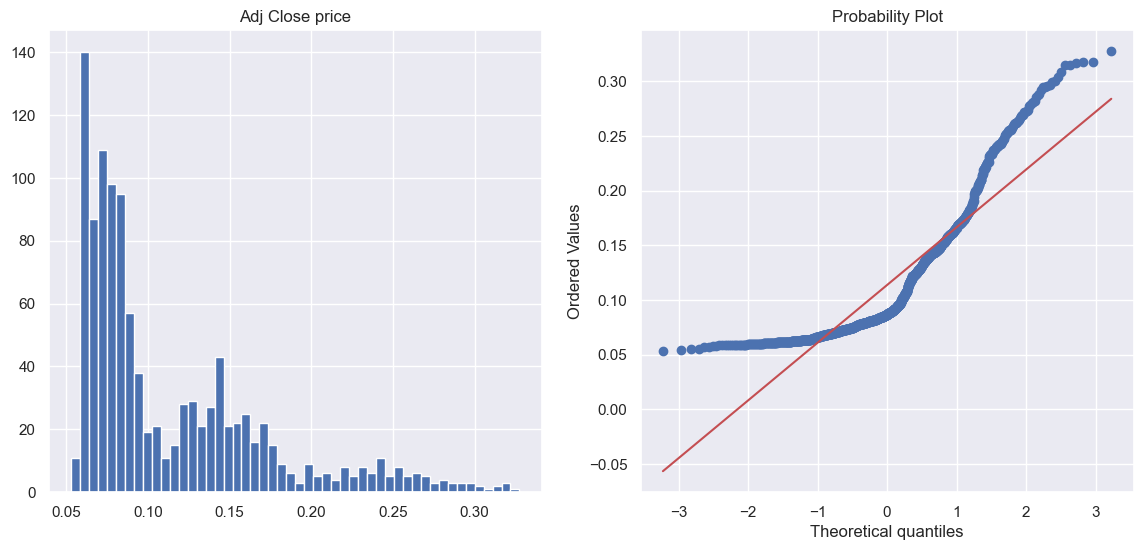

In [5]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
data['Adj Close'].hist(bins=50)
plt.title('Adj Close price')
plt.subplot(1,2,2)
stats.probplot(data['Adj Close'], plot=plt);
data['Adj Close'].describe().T

In [6]:
from statsmodels.tsa.stattools import adfuller

adfuller(data['returns'].dropna())

(np.float64(-9.208155701781076),
 np.float64(1.919740493252803e-15),
 15,
 1088,
 {'1%': np.float64(-3.4363746281360426),
  '5%': np.float64(-2.864200133611212),
  '10%': np.float64(-2.568186343567528)},
 np.float64(-3549.5405063695325))

Series is stationary

In [7]:
data['smoothed_returns'] = data['returns'].rolling(window=3).mean().dropna()
data['state'] = data['returns'].apply(lambda x: 'up' if (x > 0.002)\
else ('down' if (x < -0.002)\
else 'no_change'))
data.tail()

,High,Low,Open,Adj Close,Volume,returns,smoothed_returns,state
Date,,,,,,,,
2024-08-21,0.107825,0.102462,0.103000,0.106157,509933481,0.030180,0.019343,up
2024-08-22,0.106822,0.104274,0.106157,0.105308,391690266,-0.008030,0.012264,down
2024-08-23,0.115239,0.105305,0.105308,0.112927,860650259,0.069852,0.030668,up
2024-08-24,0.114947,0.111247,0.112927,0.112631,673199379,-0.002625,0.019733,down
2024-08-26,0.110270,0.108475,0.109698,0.109286,557720448,-0.030146,0.012361,down


In [8]:
data['prev_state'] = data['state'].shift(1)
data.tail()

,High,Low,Open,Adj Close,Volume,returns,smoothed_returns,state,prev_state
Date,,,,,,,,,
2024-08-21,0.107825,0.102462,0.103000,0.106157,509933481,0.030180,0.019343,up,up
2024-08-22,0.106822,0.104274,0.106157,0.105308,391690266,-0.008030,0.012264,down,up
2024-08-23,0.115239,0.105305,0.105308,0.112927,860650259,0.069852,0.030668,up,down
2024-08-24,0.114947,0.111247,0.112927,0.112631,673199379,-0.002625,0.019733,down,up
2024-08-26,0.110270,0.108475,0.109698,0.109286,557720448,-0.030146,0.012361,down,down


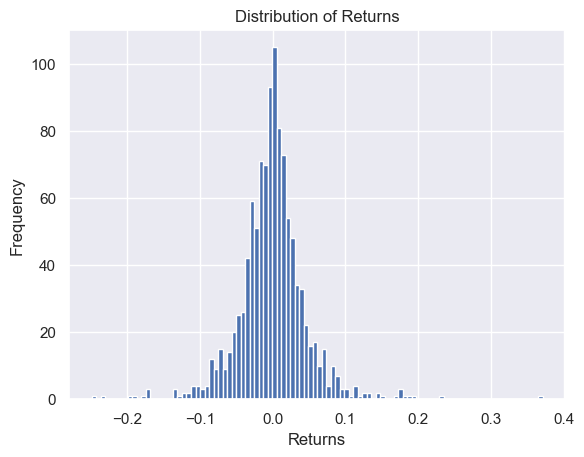

In [9]:
data['returns'].hist(bins=100)
plt.title('Distribution of Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

In [10]:
state_space = data[['prev_state', 'state']]
state_space_matrix = data.groupby(['prev_state', 'state']).size().unstack()
state_space_matrix

state,down,no_change,up
prev_state,,,
down,224,38,266
no_change,34,6,29
up,271,25,210


In [11]:
print(state_space_matrix.sum())

state
down         529
no_change     69
up           505
dtype: int64


In [12]:
transition_matrix = state_space_matrix.apply(lambda x: x/float(x.sum()), axis=1)
transition_matrix

state,down,no_change,up
prev_state,,,
down,0.424242,0.071970,0.503788
no_change,0.492754,0.086957,0.420290
up,0.535573,0.049407,0.415020


In [13]:
print(transition_matrix.sum(axis=1))

prev_state
down         1.0
no_change    1.0
up           1.0
dtype: float64


In [14]:
t0 = transition_matrix.copy()
t1 = round(t0.dot(t0), 4)
t1
t2 = round(t0.dot(t1), 4)
t2
t3 = round(t0.dot(t2), 4)
t3

state,down,no_change,up
prev_state,,,
down,0.4796,0.0626,0.4578
no_change,0.4795,0.0626,0.4579
up,0.4794,0.0626,0.4580


In [15]:
pd.DataFrame(np.linalg.matrix_power(t0,4))

<IPython.core.display.Javascript object>

,0,1,2
0,0.479572,0.062566,0.457862
1,0.479485,0.062581,0.457935
2,0.479447,0.062586,0.457967


In [16]:
# find the equilibrium matrix
i=1
a= t0.copy()
b = t0.dot(t0)
while(not(a.equals(b))):
  print('iteration number:' +str(i))
  i += 1
  a = b.copy()
  b = b.dot(t0)

iteration number:1
iteration number:2
iteration number:3
iteration number:4
iteration number:5
iteration number:6
iteration number:7
iteration number:8
iteration number:9
iteration number:10
iteration number:11
iteration number:12
iteration number:13
iteration number:14
iteration number:15
iteration number:16
iteration number:17
iteration number:18
iteration number:19


In [17]:
from pprint import pprint 

# create a function that maps transition probability dataframe 
# to markov edges and weights

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(transition_matrix)
pprint(edges_wts)
     

{('down', 'down'): np.float64(0.42424242424242425),
 ('down', 'no_change'): np.float64(0.07196969696969698),
 ('down', 'up'): np.float64(0.5037878787878788),
 ('no_change', 'down'): np.float64(0.4927536231884058),
 ('no_change', 'no_change'): np.float64(0.08695652173913043),
 ('no_change', 'up'): np.float64(0.42028985507246375),
 ('up', 'down'): np.float64(0.5355731225296443),
 ('up', 'no_change'): np.float64(0.04940711462450593),
 ('up', 'up'): np.float64(0.4150197628458498)}


Nodes:
['down', 'no_change', 'up']

Edges:


<IPython.core.display.Javascript object>

           0          1                                                  2
0       down       down  {'weight': 0.42424242424242425, 'label': 0.424...
1       down  no_change  {'weight': 0.07196969696969698, 'label': 0.071...
2       down         up  {'weight': 0.5037878787878788, 'label': 0.5037...
3  no_change       down  {'weight': 0.4927536231884058, 'label': 0.4927...
4  no_change  no_change  {'weight': 0.08695652173913043, 'label': 0.086...
5  no_change         up  {'weight': 0.42028985507246375, 'label': 0.420...
6         up       down  {'weight': 0.5355731225296443, 'label': 0.5355...
7         up  no_change  {'weight': 0.04940711462450593, 'label': 0.049...
8         up         up  {'weight': 0.4150197628458498, 'label': 0.4150...
None


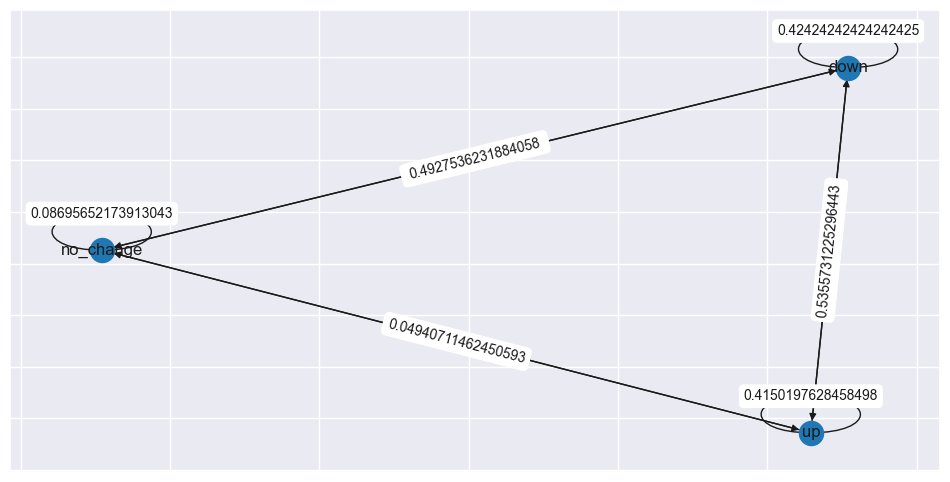

In [18]:
import networkx as nx
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
states = ['up', 'down', 'no_change']

# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(state_space_matrix)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
print(f'Edges:')
pprint(pd.DataFrame(G.edges(data=True)))    

plt.figure(figsize=(12,6))
pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
print(nx.draw_networkx(G, pos))


edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'nasdaq_markov.dot')

c:\Users\ashda\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                returns   No. Observations:                 1102
Model:               MarkovRegression   Log Likelihood                1994.446
Date:                Sun, 25 Aug 2024   AIC                          -3964.892
Time:                        22:48:50   BIC                          -3904.833
Sample:                             0   HQIC                         -3942.173
                               - 1102                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -1.348      0.178      -0.005       0.001
sigma2         0.0016      0.000     10.620      0.0

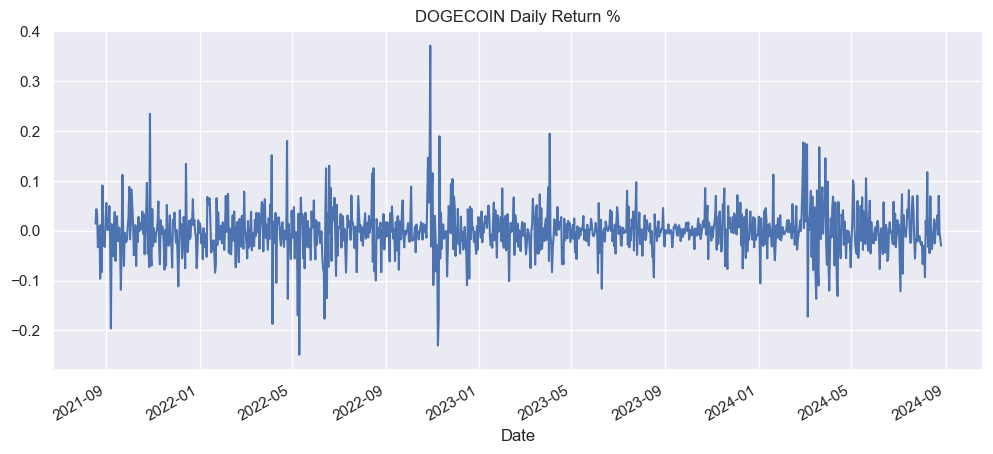

In [19]:
import statsmodels.api as sm

# Plot the data
data['returns'].plot(title='DOGECOIN Daily Return %', figsize=(12,5))

data.dropna(inplace=True)

model = sm.tsa.MarkovRegression(data['returns'][-2500:], k_regimes=3, switching_variance=True)

np.random.seed(274)
res_1 = model.fit(search_reps=50)

"""We specify that 50 random perturbations from the starting parameter 
vector are examined and the best one used as the actual starting parameters. 

Because of the random nature of the search, the random seed generator 
beforehand allow replication of the result"""

print(res_1.summary())

In [20]:
pred_1 = res_1.predict()
pred_1 = pd.DataFrame(pred_1).tail(20)
pred_1.rename(columns ={0: 'Predicted'}, inplace=True)
com_1 = pd.concat([pred_1, data['returns'].tail(20)], axis=1)
com_1 = com_1.reset_index()
com_1
     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Date,Predicted,returns
0,2024-08-06,-0.001522,0.019574
1,2024-08-07,-0.001343,-0.008922
2,2024-08-08,-0.000797,0.117314
3,2024-08-09,-0.001502,-0.032457
4,2024-08-10,-0.001787,0.011741
5,2024-08-11,-0.001913,-0.045068
6,2024-08-12,-0.001967,0.069157
7,2024-08-13,-0.002013,-0.012616
8,2024-08-14,-0.002048,-0.036957
9,2024-08-15,-0.001889,-0.022563


In [21]:
%pip install plotly
%pip install nbformat
fig = go.Figure()
fig.add_trace(go.Scatter(x=com_1['index'],y=com_1['returns'], name="Actual returns"))
fig.add_trace(go.Scatter(x=com_1['index'],y=com_1['Predicted'], name="Predicted return"))
fig.update_layout(title="DOGE Actual vs Predicted returns", yaxis_title="Price ($)", font=dict(family="Courier New, monospace",size=18,color="#7f7f7f"))
fig.update_layout(autosize=False,width=800,height=400,)
fig.update_layout(legend_orientation="h")
fig.show()

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyError: 'index'

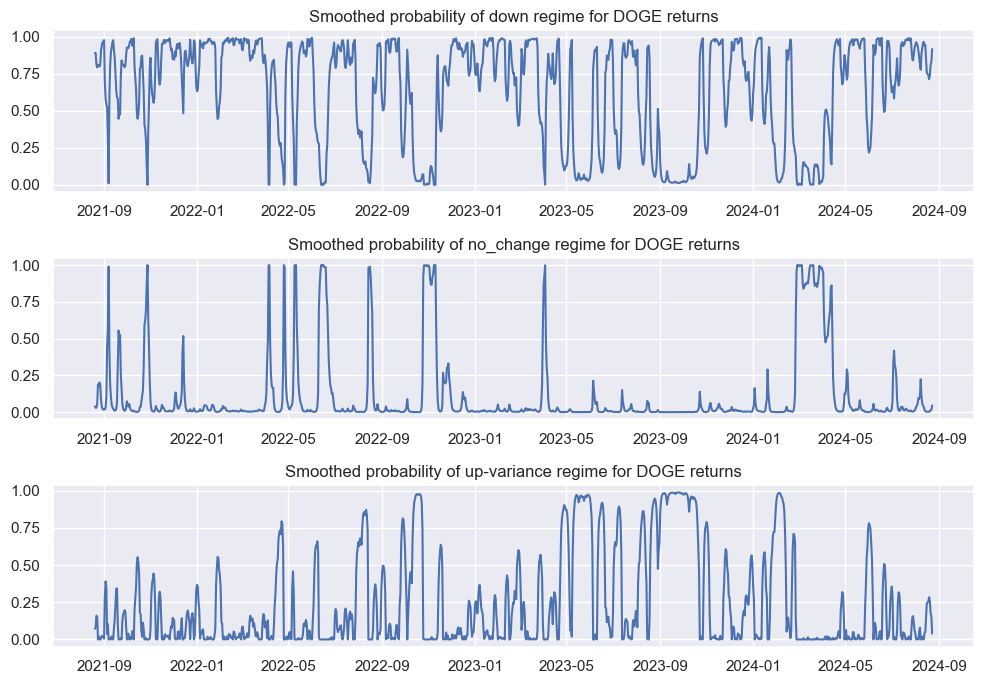

In [ ]:
fig, axes = plt.subplots(3, figsize=(10,7))
ax = axes[0]
ax.plot(res_1.smoothed_marginal_probabilities[0])
#ax.fill_between(data['returns'].index, 0,  where=data['returns'].values, color='gray', alpha=0.3)
ax.set(title='Smoothed probability of down regime for DOGE returns')
ax = axes[1]
ax.plot(res_1.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of no_change regime for DOGE returns')
ax = axes[2]
ax.plot(res_1.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of up-variance regime for DOGE returns')
fig.tight_layout()
     

In [ ]:
print(res_1.expected_durations)

NameError: name 'res_1' is not defined

In [ ]:
data['volume_gap'] = np.log(data['Volume'] / data['Volume'].shift()) 
data['daily_change'] = (data['Adj Close'] - data['Open']) / data['Open']
data['fract_high'] = (data['High'] - data['Open']) / data['Open']
data['fract_low'] = (data['Open'] - data['Low']) / data['Open']
data['forecast_variable'] = data['Adj Close'].diff()
data.dropna(inplace=True)
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
endog = data['forecast_variable'][-2500:]
exog = data [['volume_gap', 'daily_change', 'fract_high', 'fract_low']][-2500:]


In [ ]:
# Fit the 2-regime model
mod_2 = sm.tsa.MarkovRegression(
    endog=endog, k_regimes=3, exog=exog)
res_2 = mod_2.fit(search_reps=50)
print(res_2.summary())